# Feature Extraction
The purpose of this document is to determine the subset of features from which the best model can be obtained, without sacrificing model performance. Specifically, we will be using feature selection to select a subset of the most relevant features. Fewer features will allow the machine learning algorithm to run more efficiently and be more effective. Additionally, it is possible for machine learning algorithms to be misled by irrelevant features, resulting in worse predictive performance. Hence, in this document we will investigate the subset of features that results in both the best predictive performance and efficiency. 

Once a reduced set of optimal features is selected, we can then focus on further improving model performance by tuning hyperparameters - this will be performed in the next document.

The methods of feature selection that will be investigated here include:

1. Random Forest feature importance.
2. Covariance matrix correlation.<br>
    a. Correlation of features with the target.<br>
    b. Correlation between features.<br>
3. Sequential feature selection.<br>
    a. Forward selection.<br>
    b. Backward elimination.<br>
4. Recursive feature elimination.

To begin, we will import necessary libraries and load the raw summary data.

In [1]:
# Import necessary libraries and information.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector, RFECV, RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from lib.constants import DATA_PATH

# Load batter summary data.
summary = pd.read_csv(DATA_PATH + "/Batter_Summary.txt", delimiter="\t")


## 1. Prepare the Data.
Before feature selection can occur, we must first prepare the data. This will include:

1. Converting categorical fields to a numeric value.
2. Removing redundant fields.
3. Separating the dataset into a training and testing set.

The only non-numeric categorical data that exists within the dataset is the "Hand" field. This can be converted to a numerical category by assigning 0 to right-handed batsmen and 1 to left-handed batsmen.

The Batter_ID and Name fields of the dataset are only included to identify each record. As these fields have no importance in the modelling process, they can be removed.

To determine the performance of the model, we must split the dataset into two categories - features and targets. The features are the fields of the dataset which will be used to predict the target. Specifically, the target is each batter's International One Day batting average, while all other fields are features used to predict the batting average. Once split, we must perform a further split to separate the data into a test and training set. For this project, the test set will be the 12 most recent International One Day batters, while the training set will be all other batters. The reason for this split is to simulate how this model would be used in practice. That is, the models performance should be measured by how well it can predict the batting average of new One Day international batters.

In [2]:
# Replace batter hand with a numeric representation (Right Hand = 0, Left Hand = 1).
summary["Hand"] = np.where(summary["Hand"] == "Right", 0, 1)
summary = summary.drop(columns=["Name", "Batter_ID"])

# Extract features and labels.
X = summary.drop(columns=["International_One_Day_Batting_Average"])
y = summary["International_One_Day_Batting_Average"]

# Split the training and test datasets.
X_train = X[:-12]
X_test = X[-12:]
y_train = y[:-12]
y_test = y[-12:]

# Fill missing training data with the columns mean.
X_train = X_train.fillna(X_train.median())


## 2. Basic Hyperparameter Tuning.
The intent of this section is to obtain a set of reasonable hyperparameters for a simple Random Forest model. These hyperparameters are by no means optimised. Optimisation will occur in the next document, once the best features have been chosen for the model.

Here, we test combinations of several Random Forest hyperparameters including:

1. n_estimators - Number of trees in the forest.
2. max_features - Maximum number of features considered for splitting a node.
3. max_depth - Maximum number of levels in each decision tree.
4. min_samples_split - Minimum number of data points placed in a node before the node is split.
5. min_samples_leaf - Minimum number of data points allowed in a leaf node.
6. bootstrap - Method for sampling data points (with or without replacement).

To create an approximation of reasonable hyperparameters, we will use RandomizedSearchCV. This will allow us to test multiple combinations of the above hyperparameters without having to try all possible combinations. From the combinations tested, the optimal hyperparameters will be chosen.

Below, we create a parameter grid defining the possible values that each parameter can take.

In [4]:
# Number of trees in the forest.
n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num=40)]

# Number of features to consider at every split.
max_features = ["auto", "sqrt"]

# Maximum number of levels in each tree.
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node.
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node.
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree.
bootstrap = [True, False]

# Create the parameter grid.
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


With the parameter grid defined, we can use RandomizedSearchCV to find a reasonable combination of parameters.

In [6]:
# Create the random forest regressor.
rfr = RandomForestRegressor()

# Create the random search cross-validator.
rfr_random = RandomizedSearchCV(
    estimator=rfr, param_distributions=param_grid, n_iter=500, cv=5, verbose=2, n_jobs=-1)

# Fit the random search model.
rfr_random.fit(X_train, y_train)

# Print the best parameters for the model.
rfr_random.best_params_


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

Now, we can test the accuracy of the Random Forest using the default parameters, as well as the RandomizedSearchCV parameters.

In [3]:
rfr_accuracy = 0
rfr_random_accuracy = 0
num_tests = 200

for _ in range(num_tests):
  rfr = RandomForestRegressor()
  rfr_random = RandomForestRegressor(n_estimators=150, min_samples_split=2,
                                     min_samples_leaf=4, max_features="sqrt", max_depth=100, bootstrap=True)

  rfr.fit(X_train, y_train)
  rfr_random.fit(X_train, y_train)

  rfr_accuracy += rfr.score(X_test, y_test)
  rfr_random_accuracy += rfr_random.score(X_test, y_test)

rfr_accuracy /= num_tests
rfr_random_accuracy /= num_tests

print("Model accuracy using default parameters: {}".format(rfr_accuracy))
print("Model accuracy using RandomizedSearchCV parameters: {}".format(
    rfr_random_accuracy))


Model accuracy using default parameters: 0.6791522838685152
Model accuracy using RandomizedSearchCV parameters: 0.7435135481681531


## 3. Setup.
Below, we define two functions:

1. A function to systematically create a RandomForestRegresssor using the same hyperparameters.
2. A function to test the average accuracy of a RandomForestRegressor.

These functions aid in simplifying later code, and ensuring consistency in the testing process.

In [4]:
# Function for creating the random forest regressor.
def create_random_forest_regressor():
  # Define hyperparameters.
  n_estimators = 150
  min_samples_split = 2
  min_samples_leaf = 4
  max_features = "sqrt"
  max_depth = 100
  bootstrap = True

  # Create the model.
  rfr = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf, max_features=max_features, max_depth=max_depth, bootstrap=bootstrap)

  # Return the model.
  return rfr


In [5]:
# Function to test the average accuracy of a model for given data.
def test_average_accuracy(X_train, X_test, y_train, y_test, num_tests=250):
  accuracy = 0

  # Train and test the model repeatedly.
  for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)
    accuracy += rfr.score(X_test, y_test)

  # Return the average score for the model.
  return accuracy / num_tests


## 4. Random Forests.
Random Forests provided two useful methods for determining feature importance:

1. Feature importance based on impurity.
2. Feature importance based on permutations.

We will explore both methods in their respective sections below.

### 4.1 Feature Importance Based on Decrease in Impurity.
The standard approach of measuring feature importance in a Random Forest is based on mean decrease in impurity (MDI). MDI for a feature is calculated as the sum of the number of splits that include the feature, proportionally to the number of samples it splits.

There are two main limitations of impurity-based feature importances:

1. Impurity-based feature importances are biased towards high cardinality features
2. Impurity-based feature importances are computed on training set statistics and therefore do not reflect the ability of the feature to be useful in making predictions that generalise to the test set.

 > Note: Low importance in a bad model could be very important in a good model. For this reason, we will only record the feature importances for models with an acceptable accuracy. The feature importance for all other models will be discarded.

Feature importance based on impurity is explored below.

In [6]:
# Define and initialise variables.
num_tests = 1000
accuracy_cutoff = 0.73
num_valid = 0
feature_names = X_train.columns
impurity_importances = pd.Series(0, feature_names)

# Run tests keeping track of each features importance.
for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)

    # Determine performance of the model.
    score = rfr.score(X_test, y_test)

    # Only track the feature importance of high-performing models.
    if score > accuracy_cutoff:
        # Determine the feature importance for this run.
        temp_feature_importance = pd.Series(
            rfr.feature_importances_, index=feature_names)

        # Keep track of each runs feature importance.
        impurity_importances = impurity_importances.add(
            temp_feature_importance)

        # Track how many high-performing models occur.
        num_valid += 1

# Rescale and order the feature importance.
impurity_importances /= num_valid
impurity_importances = impurity_importances.sort_values(ascending=False)
impurity_importances


Domestic_Test_Average_Entering_Ball               0.067065
Domestic_Test_Average_Entering_Score              0.063108
Domestic_One_Day_Average_Ball_Count               0.059228
Domestic_One_Day_Runs_Per_Innings_Average         0.043697
Domestic_One_Day_Team_Run_Contribution_Percent    0.041742
                                                    ...   
Domestic_Test_300_Rate                            0.000000
Domestic_One_Day_Handled_Ball_Percent             0.000000
Domestic_T20_150_Rate                             0.000000
Domestic_T20_200_Rate                             0.000000
Domestic_One_Day_200_Rate                         0.000000
Length: 127, dtype: float64

We can visualise the importance of each feature in a bar graph. Due to the large number of features, we will be able to distinguish where each feature falls on the graph, however, it does give a sense of how widely dispersed the importance of each feature is. For example, we can see that the first quarter of features provides the most substantial contribution to the models accuracy.

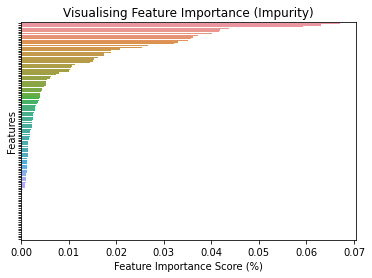

In [7]:
# Create a bar plot.
fig = plt.figure()
sns.barplot(x=impurity_importances, y=impurity_importances.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Feature Importance Score (%)")
plt.ylabel("Features")
plt.title("Visualising Feature Importance (Impurity)")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Additionally, we can visualise how the model accuracy changes by adding each of the most important features successively. Specifically, we will sequentially add the most important features as determined by the Random Forest feature selection, and observe how the model accuracy changes for each n of most important features. This will allow us to see if there are plateaus in mode accuracy, providing a bound from which the feature set can be truncated.

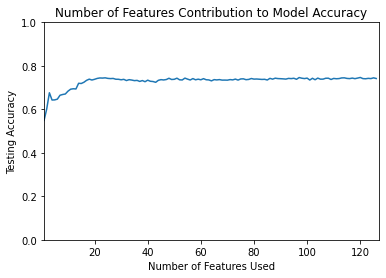

In [8]:
# Initialise an array to keep track of the accuracy for each number of features.
accuracies = []

# Determine the accuracy for each number of most important features.
for i in range(1, len(impurity_importances)):
  # Create the test and training sets for the reduced features.
  features = impurity_importances[:i].index.tolist()
  X_train_temp = X_train[features]
  X_test_temp = X_test[features]

  # Create an average accuracy.
  num_tests = 40
  accuracy = test_average_accuracy(
      X_train_temp, X_test_temp, y_train, y_test, num_tests)

  # Add the accuracy to the accuracies list.
  accuracies.append(accuracy)

# Display the accuracy.
fig = plt.figure()
plt.plot(range(1, len(impurity_importances)), accuracies)
plt.xlim([1, len(impurity_importances)])
plt.ylim([0, 1])
plt.xlabel("Number of Features Used")
plt.ylabel("Testing Accuracy")
plt.title("Number of Features Contribution to Model Accuracy")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Now, we can test how accurate the model is using the 20 most important features based on impurity.

In [9]:
# Extract the most important feature according to permutation.
important_features_impurity = impurity_importances[:20].index.tolist()
X_train_impurity = X_train[important_features_impurity]
X_test_impurity = X_test[important_features_impurity]

# Test the accuracy of the model with reduced features.
accuracy_IFE = test_average_accuracy(
    X_train_impurity, X_test_impurity, y_train, y_test)
print("The accuracy of the model using the 20 most important impurity features is: {}".format(accuracy_IFE))


The accuracy of the model using the 20 most important impurity features is: 0.7380881328268049


### 4.2 Feature Importance Based on Feature Permutation.
Permutation importance is a measure of feature importance where each feature, one-by-one, is selected and its records are randomly permuted. Permutation of highly important features should have a greater impact on model performance than permutation of less important features. In this way, we can determine which features are most important.

Permutation importance overcomes limitations in impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set. However, the effectiveness of permutation importance can be affected by the presence of strongly correlated features. For example, when two highly correlated features are present in a dataset, permuting either of the features will report a low importance, as the information is still accessible through its correlated feature. This will result in a lower importance for both features, where they may actually be important. For this reason, we explore two types of feature permutation importance.

1. Basic permutation importance (collinearity ignored).
2. Clustered permutation importance (collinearity addressed).

These are explored below.

#### 4.2.1 Basic Permutation Importance.
In this section, we will explore the permutation importance of each feature disregarding collinearity. To begin, we determine how important, on average, a feature is based on permutation importance.

In [10]:
# Define and initialise variables.
num_tests = 1000
accuracy_cutoff = 0.73
num_valid = 0
feature_names = X_train.columns
permutation_importances = pd.Series(0, feature_names)

# Run tests keeping track of each permutation feature importance.
for _ in range(num_tests):
    rfr = create_random_forest_regressor()
    rfr.fit(X_train, y_train)

    # Determine performance of the model.
    score = rfr.score(X_test, y_test)

    # Only track the feature importance of high-performing models.
    if score > accuracy_cutoff:
        # Determine the feature importance for this run.
        temp_feature_importance = permutation_importance(
            rfr, X_train, y_train, n_repeats=10, n_jobs=-1)

        # Keep track of each runs feature importance.
        permutation_importances = permutation_importances.add(
            temp_feature_importance.importances_mean)

        # Track how many high-performing models occur.
        num_valid += 1

# Rescale and order the feature importance.
permutation_importances /= num_valid
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances


Domestic_Test_Average_Entering_Ball          0.030617
Domestic_Test_Average_Entering_Score         0.028846
Domestic_One_Day_Average_Ball_Count          0.023456
Domestic_One_Day_50_Rate                     0.018638
Domestic_One_Day_Runs_Per_Innings_Average    0.014326
                                               ...   
Domestic_Test_Hit_Ball_Twice_Percent         0.000000
Domestic_Test_Handled_Ball_Percent           0.000000
Domestic_T20_300_Rate                        0.000000
Domestic_T20_250_Rate                        0.000000
Domestic_Test_250_Rate                       0.000000
Length: 127, dtype: float64

From the above, we can conclude that permuting any single feature drops the model accuracy by at most 0.0313, suggesting no features are important. However, due to the high model accuracy, we understand that some features must be important. This abnormality is likely the result of highly correlated features.

Similarly to the impurity feature importance, we can get a general sense of how important each feature is by plotting them in a bar graph.

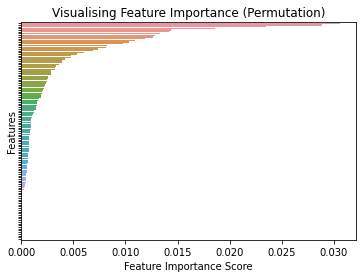

In [11]:
# Create a bar plot.
fig = plt.figure()
sns.barplot(x=permutation_importances, y=permutation_importances.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualising Feature Importance (Permutation)")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Now, we can test the model accuracy using the first 20 most important features.

In [12]:
# Extract the most important feature according to permutation.
important_features_permutation = permutation_importances[:20].index.tolist()
X_train_permutation = X_train[important_features_permutation]
X_test_permutation = X_test[important_features_permutation]

# Test the accuracy of the model with reduced features.
accuracy_PFE = test_average_accuracy(
    X_train_permutation, X_test_permutation, y_train, y_test)
print("The accuracy of the model using the 20 most important permutation features is: {}".format(accuracy_PFE))


The accuracy of the model using the 20 most important permutation features is: 0.744630699116997


#### 4.2.2 Clustered Permuation Importance.
In this section, correlated features are addressed by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. 

To begin, we will plot a heatmap of the correlated features alongside a dendrogram. The significance, and interpretation of each plot will be discussed below.

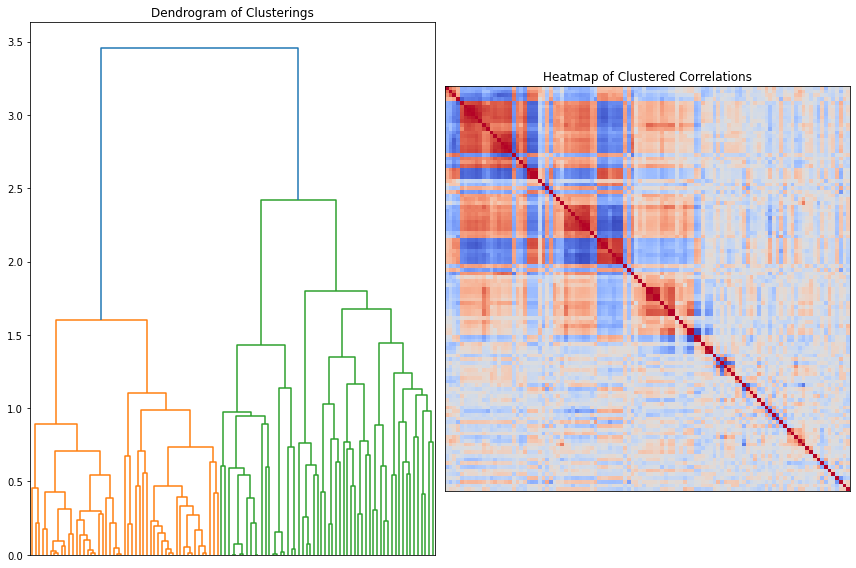

In [13]:
# Initialise the figure.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Remove any rows with no variance and determine correlation.
df = X_train.loc[:, (X_train != 0).any(axis=0)]
corr = spearmanr(df).correlation

# Ensure the correlation matrix is symmetric.
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Plot the dendrogram.
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, leaf_rotation=90
)
ax1.set_title("Dendrogram of Clusterings")
ax1.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)

# Plot the correlations in a heatmap.
ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="coolwarm")
ax2.set_title("Heatmap of Clustered Correlations")
ax2.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)
ax2.tick_params(axis="y", which='both', left=False,
                right=False, labelleft=False)

# Display the subplots.
fig.tight_layout()
plt.show()


A dendrogram has been plotted on the left. A dendrogram is formed by beginning with each feature in its own cluster. Then, the two most similar clusters are combined into a single cluster, denoted by a box-shaped link. This process is continued, reducing the number of clusters by one at each step until there is only a single cluster remaining - this is denoted by the blue link in the above diagram. Dendrograms can be used to indicate how similar clusters are based on the length of the link between two clusters - the shorter the link, the more similar the two clusters are. For example, the blue link between the orange and green clusters above is the longest in the dendrogram. So, we can determine that the green and orange clusters are very different.

On the right, a heat map of the clustered correlations is plotted. The sections with the greatest intensity along the main diagonal are representative of clusters.

From this, we can set a threshold by visual inspection of the dendrogram - say 0.5. Then, clusters are taken from below this threshold. Recalling that clusters are formed by the most similar features, and the dendrograms link lengths are indicative of how closesly related features are, by setting a threshold we are essentially grouping the most closely related features into a single group. A high threshold will result in fewer, larger clusters, while a low threshold will result in more, smaller clusters.

Once clusters are formed, we can pick a single feature from each cluster - removing the mostly highly correlated features. To ensure the best features were selected from each cluster, Sequential Feature selection was used within the clusters to choose the feature that optimised the model the most. More details on sequential feature selection will be discussed later.

In [14]:
# Extract the clusters for the given threshold.
threshold = 0.25
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Initialise the selected features.
important_features_permutation = []

# Pick the best feature from each cluster using sequential feature selection.
for cluster in cluster_id_to_feature_ids.values():
    if len(cluster) == 1:
        features = X_train.iloc[:, cluster].columns.tolist()
        important_features_permutation.append(features[0])
    else:
        rfr = create_random_forest_regressor()
        selector = SequentialFeatureSelector(
            rfr, n_features_to_select=1, n_jobs=-1)
        selector = selector.fit(X_train.iloc[:, cluster], y_train)
        features = selector.get_feature_names_out(
            X_train.iloc[:, cluster].columns.tolist())
        important_features_permutation.append(features[0])

important_features_permutation


['Hand',
 'Domestic_One_Day_Match_Count',
 'Domestic_One_Day_Win_Rate',
 'Domestic_Test_Win_Rate',
 'Domestic_T20_Match_Count',
 'Domestic_T20_Win_Rate',
 'Domestic_One_Day_Match_Percent',
 'Domestic_Test_Match_Percent',
 'Domestic_One_Day_Caught_Percent',
 'Domestic_One_Day_Bowled_Percent',
 'Domestic_One_Day_LBW_Percent',
 'Domestic_One_Day_Hit_Wicket_Percent',
 'Domestic_One_Day_Stumped_Percent',
 'Domestic_One_Day_Run_Out_Percent',
 'Domestic_One_Day_Handled_Ball_Percent',
 'Domestic_One_Day_Hit_Ball_Twice_Percent',
 'Domestic_One_Day_Obstructed_Field_Percent',
 'Domestic_One_Day_Timed_Out_Percent',
 'Domestic_Test_Not_Out_Percent',
 'Domestic_Test_Bowled_Percent',
 'Domestic_Test_Caught_Percent',
 'Domestic_Test_150_Rate',
 'Domestic_Test_Hit_Wicket_Percent',
 'Domestic_Test_Stumped_Percent',
 'Domestic_Test_Handled_Ball_Percent',
 'Domestic_Test_Hit_Ball_Twice_Percent',
 'Domestic_Test_Obstructed_Field_Percent',
 'Domestic_T20_Not_Out_Percent',
 'Domestic_T20_Bowled_Percent',
 'D

With a feature selected from each cluster, we can now test the average model accuracy for the reduced features.

In [15]:
# Extract the most important feature according to permutation.
X_train_permutation = X_train[important_features_permutation]
X_test_permutation = X_test[important_features_permutation]

# Test the accuracy of the model with reduced features.
accuracy_PFE = test_average_accuracy(
    X_train_permutation, X_test_permutation, y_train, y_test)
print("The accuracy of the model using the most important clustered permutation features is: {}".format(accuracy_PFE))


The accuracy of the model using the most important clustered permutation features is: 0.7266655192741116


## 5. Covariance Matrix - Determine the Correlation of Features.
Similarly to what was done when addressing collinearity in the permutation feature importance section, here, we will explicitly explore correlation within the model. In particular, two types of correlation will be addressed:

1. Correlation of the target with features.
2. Correlation between features.

### 5.1 Determine the Correlation of the Target with Features.
In this section, we explore the correlation the target has with features. In theory, the more strongly correlated a feature is with the target (whether negative or positive), the more important the feature should be in determining the models accuracy.

Below, we plot how strongly features are correlated with the target.

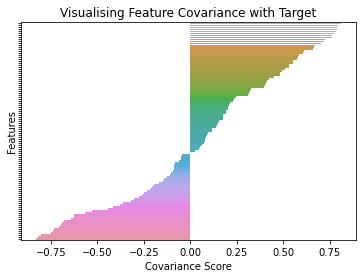

In [21]:
# Extract correlalation with the target.
data = pd.merge(left=y_train, right=X_train, left_index=True, right_index=True)
covariance = data.corr()["International_One_Day_Batting_Average"]
covariance = covariance.drop(
    "International_One_Day_Batting_Average").sort_values(ascending=False)
covariance = covariance[~covariance.isna()]

# Create a bar plot.
fig = plt.figure()
sns.barplot(x=covariance, y=covariance.index)

# Label graph.
plt.tick_params(axis="y", labelleft=False)
plt.xlabel("Covariance Score")
plt.ylabel("Features")
plt.title("Visualising Feature Covariance with Target")
fig.patch.set_facecolor((1, 1, 1))
plt.show()


Alone, this figure does not provide much insight into selecting the most optimal features for the model. However, something we may try is to see how important the correlation between the features and target is for the feature importances we calculated previously.

In [22]:
# Rank the covariance importance.
cov_ranking = covariance.to_frame().copy()
cov_ranking = cov_ranking.rename(
    {cov_ranking.columns[0]: "Correlation"}, axis=1)
cov_ranking["Correlation"] = abs(cov_ranking["Correlation"])
cov_ranking = cov_ranking.sort_values(by="Correlation", ascending=False)
cov_ranking["Correlation"] = np.arange(len(cov_ranking))

# Rank the impurity importance.
imp_ranking = impurity_importances.to_frame().copy()
imp_ranking = imp_ranking[imp_ranking.index.isin(cov_ranking.index.tolist())]
imp_ranking = imp_ranking.rename(
    {imp_ranking.columns[0]: "Impurity Ranking"}, axis=1)
imp_ranking["Impurity Ranking"] = np.arange(len(imp_ranking))

# Merge covariance importance and impurity importance for comparison.
correlation_comparison = pd.merge(
    left=imp_ranking, right=cov_ranking, left_index=True, right_index=True, how="left")
correlation_comparison[:20]


,Impurity Ranking,Correlation
Domestic_Test_Average_Entering_Ball,0,0
Domestic_Test_Average_Entering_Score,1,1
Domestic_One_Day_Average_Ball_Count,2,2
Domestic_One_Day_Runs_Per_Innings_Average,3,6
Domestic_One_Day_Team_Run_Contribution_Percent,4,5
Domestic_One_Day_Runs_Per_Out_Average,5,8
Domestic_One_Day_50_Rate,6,4
Domestic_One_Day_Average_Entering_Ball,7,11
Domestic_Test_Runs_Per_Innings_Average,8,9
Domestic_Test_Team_Run_Contribution_Percent,9,7


From this, we can see that feature importance and feature correlation with the target are highly related.

### 5.2 Determine the Correlation Between Features.
While it is important to know how related the features are to the target, it is also important to know how related the features are to eachother. Having highly correlated features can have detrimental impacts on model performance and may reduce the accuracy of claims made about the importance of features in the model. For example, in a Random Forest model, if there are highly correlated features the model can choose any of the features as an important predictor without preference for one over the other. With this feature chosen, the other features correlated with it will be assigned low importances as the impurity they are able to remove has already been removed by the chosen feature. From a model perspective, this will not reduce model accuracy. However, from an informative perspective, this would result in features being disregarded as unimportant when they may actually have a high predictive ability in the absence of other correlated features.

Below, we explore the correlation of the features in a heatmap.

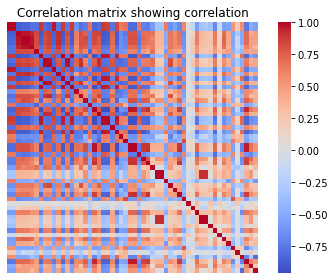

In [23]:
# Extract the correlation.
correlation = X[impurity_importances[:56].index.tolist()].corr()

# Plot the correlation matrix as a heat map.
sns.heatmap(correlation, cbar=True, square=True, cmap="coolwarm")
plt.tick_params(axis="y", which='both', left=False,
                right=False, labelleft=False)
plt.tick_params(axis="x", which='both', bottom=False,
                top=False, labelbottom=False)
plt.title("Correlation matrix showing correlation")
plt.tight_layout()
plt.show()


Based on the above figure, it would be possible to set a threshold and remove features that are highly correlated. However, it is possible for features to be highly correlated while also each providing useful information. From the context of cricket, for example, a players domestic test batting average and the number of balls they face in test cricket on average are highly correlated. However, these each provide insights into a batter that the other can't, thus, just removing correlated features is a blunt-force method that isn't recommended without further consideration.

## 6. Sequential Feature Selection.
Sequential Feature Selection is a method by which features are added or removed to form a feature subset that optimises a model. This is done in a greedy fashion, by which the best feature to add or remove is based on the cross-validation score.

In this section we explore two methods:

1. Forward Sequential Feature Selection.
2. Backward Sequential Feature Elimination.

### 6.1 Forward Sequential Feature Selection.
Forward Sequential Feature Selection (SFS) is a method by features are sequentially added to the model. First, the best single feature is selected, then a second feature that produces the best model in combination with the first, and so on, until the desired number of features are selected.

Below, we investigate this approach.

In [24]:
# Create and train an SFS selector.
rfr = create_random_forest_regressor()
selector_SFS = SequentialFeatureSelector(
    rfr, n_features_to_select=30, n_jobs=-1)
selector_SFS = selector_SFS.fit(X_train, y_train)


With the SFS selector trained, we can determine which features Successive Forward Selection chose as the most important.

In [25]:
# Extract the features chosen by SFS.
features_SFS = selector_SFS.get_feature_names_out(X_train.columns.tolist())
features_SFS


array(['Domestic_One_Day_Match_Count', 'Domestic_T20_Match_Percent',
       'Domestic_One_Day_Innings_Percent',
       'Domestic_Test_Innings_Percent', 'Domestic_T20_Innings_Percent',
       'Domestic_One_Day_Stumped_Percent', 'Domestic_Test_Bowled_Percent',
       'Domestic_T20_Not_Out_Percent', 'Domestic_T20_Bowled_Percent',
       'Domestic_T20_Hit_Ball_Twice_Percent',
       'Domestic_T20_Obstructed_Field_Percent',
       'Domestic_One_Day_One_Rate',
       'Domestic_One_Day_Runs_Per_Innings_Average',
       'Domestic_Test_Three_Rate', 'Domestic_Test_Runs_Per_Out_Average',
       'Domestic_T20_Two_Rate', 'Domestic_One_Day_Duck_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_One_Day_150_Rate',
       'Domestic_One_Day_300_Rate', 'Domestic_Test_200_Rate',
       'Domestic_Test_300_Rate', 'Domestic_T20_200_Rate',
       'Domestic_T20_250_Rate', 'Domestic_T20_300_Rate',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic

Now, we can determine the accuracy of the Random Forest model, using the SFS feature set.

In [26]:
# Create a new reduced dataset from the SFS features.
X_train_SFS = X_train[features_SFS]
X_test_SFS = X_test[features_SFS]

# Print the accuracy using RFE features.
accuracy_SFS = test_average_accuracy(X_train_SFS, X_test_SFS, y_train, y_test)
print("The accuracy using features from Successive Forward Selection is: {}".format(accuracy_SFS))


The accuracy using features from Successive Forward Selection is: 0.6981274309886931


### 6.2 Backward Elimination Feature Selection.
Backward Sequential Feature Selection (SBS) is a method by features are sequentially removed from the model. The model begins with n features, then for each subset with n-1 features the model is tested, and the worst feature is discarded. This is repeated for subsets n-2, n-3, ..., until the desired number of features remain.

Below, we investigate this approach.

In [27]:
# Create and train an SBS selector.
rfr = create_random_forest_regressor()
selector_SBS = SequentialFeatureSelector(
    rfr, direction="backward", n_features_to_select=30, n_jobs=-1)
selector_SBS = selector_SBS.fit(X_train, y_train)


With the SBS selector trained, we can determine which features Successive Backward Selection chose as the most important.

In [28]:
# Extract the features chosen by SBS.
features_SBS = selector_SBS.get_feature_names_out(X_train.columns.tolist())
features_SBS


array(['Hand', 'Domestic_One_Day_Innings_Count',
       'Domestic_Test_Match_Count', 'Domestic_T20_Innings_Count',
       'Domestic_T20_Match_Percent', 'Domestic_One_Day_Not_Out_Percent',
       'Domestic_One_Day_Handled_Ball_Percent',
       'Domestic_Test_LBW_Percent', 'Domestic_T20_Bowled_Percent',
       'Domestic_T20_Stumped_Percent',
       'Domestic_T20_Handled_Ball_Percent',
       'Domestic_T20_Obstructed_Field_Percent',
       'Domestic_One_Day_Dot_Rate',
       'Domestic_One_Day_Runs_Per_Out_Average',
       'Domestic_One_Day_High_Score', 'Domestic_Test_Dot_Rate',
       'Domestic_Test_One_Rate', 'Domestic_T20_Dot_Rate',
       'Domestic_T20_Four_Rate', 'Domestic_T20_Six_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_Test_300_Rate',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic_Test_Average_Entering_Score',
       'Domestic_T20_Average_Entering_Score',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic_One_Day_False_Shot_Rate', 'Domestic_T20

Now, we can determine the accuracy of the Random Forest model, using the SBS feature set.

In [29]:
# Create a new reduced dataset from the SBS features.
X_train_SBS = X_train[features_SBS]
X_test_SBS = X_test[features_SBS]

# Print the accuracy using RFE features.
accuracy_SBS = test_average_accuracy(X_train_SBS, X_test_SBS, y_train, y_test)
print("The accuracy using features from Successive Backward Selection is: {}".format(accuracy_SBS))


The accuracy using features from Successive Backward Selection is: 0.7270079542434167


## 7. Recursive Feature Elimination.
Recursive Feature Elimination (RFE) is a method of feature selection by which features are successively removed until the required number of features remain. This occurs by repeatedly fitting a model, ranking its features by importance, and removing the least important features.

Below, we explore the use of this technique.

In [30]:
# Create and train an RFE selector.
rfr = create_random_forest_regressor()
selector_RFE = RFECV(rfr, min_features_to_select=10, n_jobs=-1)
selector_RFE = selector_RFE.fit(X_train, y_train)


With the RFE selector trained, we can determine which features Recursive Feature Elimination selected as the most important.

In [31]:
# Extract the features chosen by RFE.
features_RFE = selector_RFE.get_feature_names_out(X_train.columns.tolist())
features_RFE


array(['Domestic_One_Day_Innings_Count', 'Domestic_One_Day_Match_Count',
       'Domestic_One_Day_Runs_Per_Innings_Average',
       'Domestic_One_Day_Runs_Per_Out_Average',
       'Domestic_One_Day_High_Score',
       'Domestic_Test_Runs_Per_Innings_Average',
       'Domestic_Test_Runs_Per_Out_Average', 'Domestic_Test_High_Score',
       'Domestic_T20_Four_Rate', 'Domestic_One_Day_Start_Rate',
       'Domestic_One_Day_50_Rate', 'Domestic_Test_Start_Rate',
       'Domestic_Test_50_Rate', 'Domestic_One_Day_Average_Entering_Ball',
       'Domestic_One_Day_Average_Entering_Score',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Ball',
       'Domestic_Test_Average_Entering_Score',
       'Domestic_T20_Average_Entering_Score',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic_Test_Average_Ball_Count',
       'Domestic_T20_Average_Ball_Count',
       'Domestic_One_Day_Team_Run_Contribution_Percent',
       'Domestic_One_Day_Team_High_Sco

Now, we can determine the accuracy of the Random Forest model, using the RFE feature set.

In [32]:
# Create a new reduced dataset from the RFE features.
X_train_RFE = X_train[features_RFE]
X_test_RFE = X_test[features_RFE]

# Print the accuracy using RFE features.
accuracy_RFE = test_average_accuracy(X_train_RFE, X_test_RFE, y_train, y_test)
print("The accuracy using features from Recursive Feature Elimination is: {}".format(accuracy_RFE))


The accuracy using features from Recursive Feature Elimination is: 0.7148435708395857


## 8. Combination of Feature Selection Techniques.
Having gained insight into the different possible methods of feature selection, in this section, we investigate how the methods can be combined to produce the best possible reduced feature set. This includes several steps:

1. Removal of redundant features.
2. Elimination of highly correlated and similar features.
3. Recursive elimination of remaining features.

We will begin by removing redundant features. For a variety of reasons, some features in the summary dataset are zero for all players. These features, which have no variance, do not contribute any meaningful data to the model and can be removed. 

In [33]:
# Remove columns with no variance (this is equivalent to columns of 0's in this case).
X_train_reduced = X_train.loc[:, (X_train != 0).any(axis=0)]


Next, we will determine which features are most closely correlated using clustering.

In [34]:
corr = spearmanr(X_train_reduced).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

threshold = 0.2
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(X_train_reduced.columns[idx])

cluster_id_to_feature_ids


defaultdict(list,
            {69: ['Hand'],
             32: ['Domestic_One_Day_Innings_Count',
              'Domestic_One_Day_Match_Count',
              'Domestic_Test_Innings_Count',
              'Domestic_Test_Match_Count'],
             19: ['Domestic_One_Day_Win_Rate'],
             56: ['Domestic_Test_Win_Rate'],
             33: ['Domestic_T20_Innings_Count', 'Domestic_T20_Match_Count'],
             35: ['Domestic_T20_Win_Rate'],
             41: ['Domestic_One_Day_Match_Percent',
              'Domestic_One_Day_Innings_Percent'],
             40: ['Domestic_Test_Match_Percent',
              'Domestic_T20_Match_Percent',
              'Domestic_Test_Innings_Percent',
              'Domestic_T20_Innings_Percent'],
             14: ['Domestic_One_Day_Not_Out_Percent'],
             16: ['Domestic_One_Day_Bowled_Percent'],
             15: ['Domestic_One_Day_Caught_Percent'],
             30: ['Domestic_One_Day_LBW_Percent'],
             72: ['Domestic_One_Day_Hit_Wicket_Per

From the above, and using cricketing domain knowledge, we will remove the least important and most highly correlated features from the set.

In [35]:
# Remove highly correlated features from the above findings.
X_train_reduced = X_train_reduced.drop(columns=[
    "Domestic_One_Day_Innings_Count",
    "Domestic_Test_Innings_Count",
    "Domestic_T20_Innings_Count",
    "Domestic_One_Day_Innings_Percent",
    "Domestic_Test_Innings_Percent",
    "Domestic_T20_Innings_Percent",
    "Domestic_One_Day_Average_Entering_Ball",
    "Domestic_One_Day_Average_Entering_Score",
    "Domestic_Test_Average_Entering_Ball",
    "Domestic_Test_Average_Entering_Score",
    "Domestic_T20_Average_Entering_Ball",
    "Domestic_T20_Average_Entering_Score",
    "Domestic_One_Day_Runs_Per_Innings_Average",
    "Domestic_Test_Runs_Per_Innings_Average",
    "Domestic_T20_Runs_Per_Innings_Average",
])


With the strongest correlations removed from the dataset, we can now use recursive feature elimination to select the final feature set.

In [36]:
# Create a blank Random Forest Regressor.
rfr = create_random_forest_regressor()

# Use recursive feature selection to choose the best remaining features.
selector_RFE = RFE(rfr, n_features_to_select=20)
selector_RFE = selector_RFE.fit(X_train_reduced, y_train)
reduced_features = selector_RFE.get_feature_names_out(
    X_train_reduced.columns.tolist())


To test the reduced feature set, we will reconstruct our training and testing sets.

In [41]:
# Create a new reduced training and test set.
X_reduced = X[reduced_features]
X_train_reduced = X_reduced[:-12]
X_test_reduced = X_reduced[-12:]

# We must fill missing data with the columns median.
X_train_reduced = X_train_reduced.fillna(X_train_reduced.median())


Below, we print out what the most important features chosen were.

In [42]:
# Print the reduced feature set.
reduced_features


array(['Domestic_One_Day_Match_Count', 'Domestic_T20_Not_Out_Percent',
       'Domestic_One_Day_Runs_Per_Out_Average',
       'Domestic_One_Day_High_Score',
       'Domestic_Test_Runs_Per_Out_Average', 'Domestic_Test_High_Score',
       'Domestic_One_Day_Start_Rate', 'Domestic_One_Day_50_Rate',
       'Domestic_Test_Start_Rate', 'Domestic_Test_50_Rate',
       'Domestic_One_Day_Average_Entering_Wicket',
       'Domestic_Test_Average_Entering_Wicket',
       'Domestic_One_Day_Average_Ball_Count',
       'Domestic_Test_Average_Ball_Count',
       'Domestic_Test_False_Shot_Rate', 'Domestic_T20_Average_Ball_Count',
       'Domestic_One_Day_Team_Run_Contribution_Percent',
       'Domestic_One_Day_Team_High_Score_Percent',
       'Domestic_Test_Team_Run_Contribution_Percent',
       'Domestic_Test_Team_High_Score_Percent'], dtype=object)

Finally, we can test the accuracy of the model using the reduced feature set.

In [43]:
# Test the accuracy of the model with reduced features.
accuracy_CFE = test_average_accuracy(
    X_train_reduced, X_test_reduced, y_train, y_test)
print("The accuracy of the model after feature selection is: {}".format(accuracy_CFE))


The accuracy of the model after feature selection is: 0.7788542938553894


### Write Reduced Summary to File.
With the number of features reduced, we will create a new summary dataset and save it to file for later use.

In [ ]:
# Create a new dataframe of the reduced dataset.
fields = reduced_features.tolist() + ["Batter_ID", "Name", "International_One_Day_Batting_Average"]
summary_reduced = summary[fields]

# Write the reduced dataset to file.
summary_reduced.to_csv(DATA_PATH + "/Batter_Summary_Reduced.txt", sep="\t", index=False)